# MODULE

In [ ]:
# Basic module
import os, glob, cv2, re
import numpy as np
import pandas as pd

# Visualization
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# To choose random sample in Brain Sequence data
import tensorflow as tf 
from random import seed as random_seed
random_seed(50)

from numpy.random import seed as np_random_seed
np_random_seed(50)
tf.random.set_seed(50)

# Dicom image preprocess
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

# Deep learning
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing import image

# DATA

Each independent case has a dedicated folder identified by a five-digit number. 

Within each of these “case” folders, there are four sub-folders, each of them corresponding to each of the structural multi-parametric MRI (mpMRI) scans, in DICOM format. The exact mpMRI scans included are:

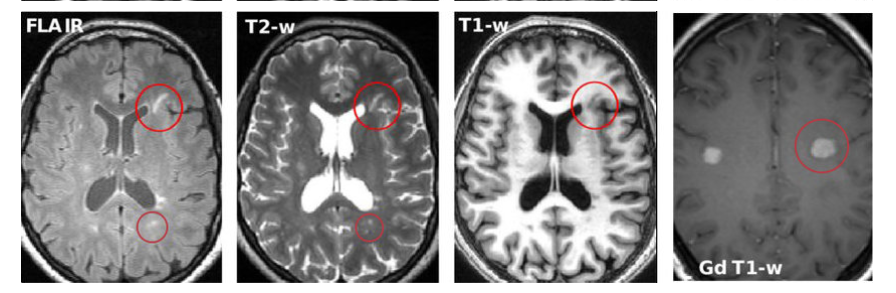

- Fluid Attenuated Inversion Recovery (FLAIR)
- T1-weighted pre-contrast (T1w)
- T1-weighted post-contrast (T1Gd)
- T2-weighted (T2)

# DATA LOAD

In [ ]:
'''
Make Data Frame for BraTS Train labels 
and sample submission labels data

change directory for your file directory!
'''

data_directory =  '../input/rsna-miccai-brain-tumor-radiogenomic-classification/'

train_df = pd.read_csv(data_directory+"train_labels.csv")
train_df['BraTS21ID5'] = [format(x, '05d') for x in train_df.BraTS21ID] # -> ZFILL 5
train_df

In [ ]:
test = pd.read_csv(
    data_directory+'sample_submission.csv')

test['BraTS21ID5'] = [format(x, '05d') for x in test.BraTS21ID]
test.head(3)

# PREPROCESS DICOM DATA

- Use weights Pre-trained on ImageNet
- feature extractor model : Xception
- Train model : LSTM

## Data condition

[ pretrained model: Xception] 

1. default input image size : 299 x 299

2.  valiable data format

- 'channels_first' data format(channels, height, width).
- 'channels_last' data format(height, width, channels).

In [ ]:
IMAGE_SIZE = 299 # Xception default input size 
SCALE = .8
NUM_IMAGES = 64
MRI_TYPE = "FLAIR"
# MRI_TYPE = ["FLAIR","T1w","T1Gd","T2"]

''' 
MRI_TYPE(multi-parametric MRI (mpMRI)) scans has four category.
we train for FLAIR in MRI_TYPE.
- Fluid Attenuated Inversion Recovery (FLAIR)
- T1-weighted pre-contrast (T1w)
- T1-weighted post-contrast (T1Gd)
- T2-weighted (T2)
'''

## Data processing function

1. Load a DCIM(Data Center Infrastructure Management) type image 

- method of loading & building data by accessing the id path using a generator.
-  After loading individual data, crop and rotate augmentation are performed.
-  Finally, data type, color is mediated, and scale normalize.

2. Apply preprocess steps such as crop & resize & rotate & normalization.

[Data Normalization]

- convert gray scale to rgb (color emd),
- `preprocess_input` function: sample-wise normalization
- scale pixels 0 ~ 255 into -1 ~ 1

[Data Preprocess] 

- resize
    
    Xception default size: 299 x 299
    
- frame of samples are all different, so All samples were unified 60 frame.
    
    if frame num is smaller than 60, add image padding with 0(zero) for last frame

In [ ]:
# Preprocess Image Fucntion

'''
****************************************************
PARAMETERS
****************************************************
  - path : String
      Path to the DCIM image file to load.
  - img_size : Integer
      Image size desired for resizing.
  - scale : Float
      Desired scale for the cropped image
  - prep : Bool
      True for a full preprocessing with denoising.
'''

def load_dicom_image(
    path,
    img_size = IMAGE_SIZE,
    scale = SCALE,
    rotate=0):

    # Load single image
    img = dicom.read_file(path).pixel_array
    
    # Crop image
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale # center 확인
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2 # scale 적용범위 확인
    img = img[int(top_y):int(bottom_y), int(left_x):int(right_x)] # 범위에 맞춰 crop
    
    # rotate image
    if rotate>0:
        rot_choices=[0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        img-cv2.rotate(img, rot_choices[rotate])
    
    # Resize image
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA) ## interpolation 지정이 안돼있음
    
    # img normaliztaion
    img = img.astype(np.float32)
    img = img/img.max() * 255
    
    # Convert in 3D array
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img=np.nan_to_num(img)

#     print(img.dtype) # float32
#     print(img.max(),"||",img.min()) #  255.0 || 0.0
    
    return preprocess_input(img)  

In [ ]:
# Test sample image loading & plot

sample_img = dicom.read_file(data_directory+"train/00052/FLAIR/Image-50.dcm").pixel_array
preproc_img = load_dicom_image(data_directory+"train/00052/FLAIR/Image-50.dcm")


fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(1,2,1)
ax1.imshow(sample_img, cmap="gray")
ax1.set_title(f"Original image shape = {sample_img.shape}")
ax2 = plt.subplot(1,2,2)
ax2.imshow(preproc_img[:,:], cmap="gray")
ax2.set_title(f"Preproc image shape = {preproc_img.shape}")
plt.show()

In [ ]:
def load_dicom_images_3d(
    scan_id, 
    num_imgs=NUM_IMAGES, 
    img_size=IMAGE_SIZE, 
    mri_type=MRI_TYPE, 
    split="train",
    rotate=0):
    '''
    This function allows loading an ordered sequence 
    of x preprocessed images starting from the central 
    image of each folder.
    ****************************************************
    PARAMETERS
    ****************************************************
    - scan_id : String
        ID of the patient to load.
    - num_imgs : Integer
        Number of desired images of the 
        sequence.
    - img_size : Integer
        Image size desired for resizing.
    - scale : Float
        Desired scale for the cropped image
    - mri_type : String
        Type of scan to load (FLAIR, T1w, 
        T1wCE, T2).
    - split : String
        Type of split desired : Train or Test
    '''
    files = sorted(glob.glob(f"{data_directory}{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2 # 64//2 =32
    p1 = max(0, middle - num_imgs2)  
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f) for f in files[p1:p2]]) 
    
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((num_imgs 

- img3d.shape[0], img_size, img_size, 3))
        img3d = np.concatenate((img3d,  n_zero), axis = 0)
            
    return np.expand_dims(img3d,0)

In [ ]:
# Test sample image loading & plot

sample_seq = load_dicom_images_3d("00046")
print("Shape of the sequence is:", sample_seq.shape)
print("Dimension of the 15th image in sequence is:", sample_seq[0,15].shape)
fig = plt.figure(figsize=(5,5))
plt.imshow(np.squeeze(sample_seq[0][15][:,:,0]), cmap="gray")
plt.show()

# Basic Information

- Pre-trained model(feature extraction) : Xception

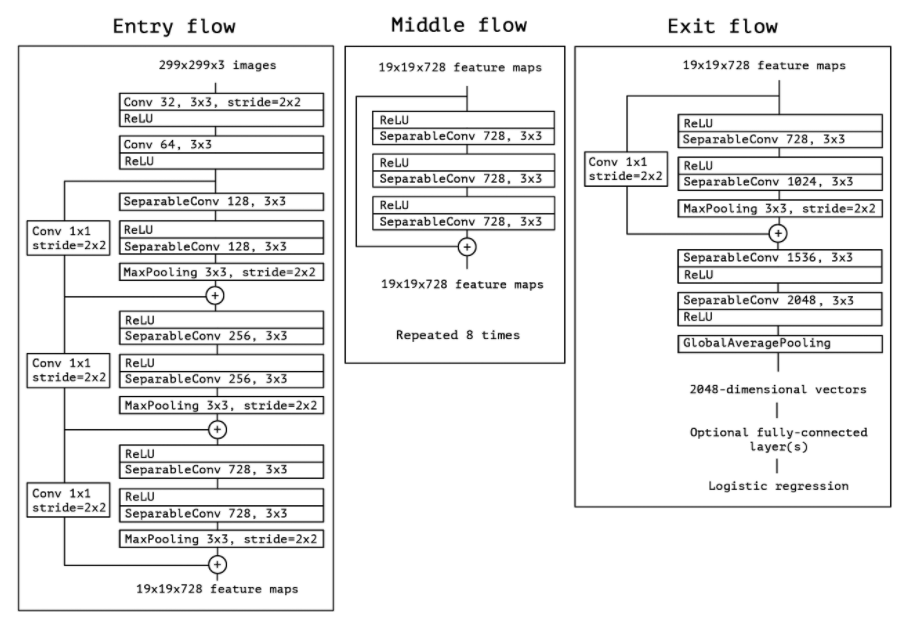

In order to further emphasize the feature of the common area shared by each frame, 

we use model which has strong cross-channels correlation and spatial correlation, in tShe feature extracurricular process

- Pre-trained model Chracter

1) Transfer learning

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.

2) fine-tuning

fine-tuning consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate.

→ we keep freezing entire model layers.

# ConvNet Feature Extracture

In [ ]:
train = train_df[['BraTS21ID5','MGMT_value']]
X_train = train['BraTS21ID5'].values
y_train = train['MGMT_value'].values

In [ ]:
base_resnet = Xception(    
    weights=None,
    pooling='avg',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False)

base_resnet.trainable = False

## Feature Extract

In this part of Transfer Learning, predictions are made only for each image of each patient's sequence without training the Xception model.

Therefore, we will obtain a matrix of model weights to be integrated into the list to reproduce patient sequences for each image.

In [ ]:
'''
Feature Extract
we use convnet model(InceptionResNetV2) for Feature Extraction
'''

listMatrix = []
for patient in tqdm(X_train):
    listVectors = []
    sequence = load_dicom_images_3d(scan_id=str(patient),mri_type=MRI_TYPE)
    for j in range(sequence.shape[1]):
        img = sequence[:,j,...]
#         img = np.expand_dims(img, axis=0)
#         img = tf.keras.applications.resnet50.preprocess_input(img)
        img_vector = base_resnet.predict(img)
        listVectors.append(np.array(img_vector))
    
    PatientMatrix = np.stack(listVectors)
    listMatrix.append(PatientMatrix)

In [ ]:
listMatrix = np.array(listMatrix)

In [ ]:
# np.save('./listMatrix',listMatrix)
# listMatrix=np.load('./listMatrix.npy')

Finally, we will create a global matrix that groups sequences of Xception for all patients.

In [ ]:
print(f"Number of Patient matrix: {len(listMatrix)}")
print(f"Patient matrix shape: {listMatrix[0].shape}")

# TRAIN

for sequence data, chain structure model is used

In [ ]:
model_input_dim = listMatrix[0].shape[2]
model_input_dim=2048

In [ ]:
# Create a function for lstm model
def get_sequence_model():

    '''Define the LSTM architecture'''

    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(512, input_shape=(NUM_IMAGES, model_input_dim), return_sequences=True))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

In [ ]:
model = get_sequence_model()
model.summary()

## MODEL TRAIN  PARAMETER

- Loss function : Mean Square Error(mse)
- Optimizer : RMSprop, , learning rate= 1e-3
- Metrics : accuracy

## EVALUATION

- 5-fold cross validation method
- Train data num: 468
- Validation data num: 117

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers

version="xception_6"
output_path=os.path.join("./result", version)

inputs2 = np.array(listMatrix)
# inputs2 = (inputs2-inputs2.min())/(inputs2.max()-inputs2.min())
inputs=inputs2[:,:,0,:]
targets = np.array(y_train).astype('float32').reshape((-1,1))

num_folds = 5

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
history = {}
fold_no = 1
for train_idx, valid_idx in kfold.split(inputs, targets):
    
    print("train: ",len(train_idx), "val: ", len(valid_idx))
    
    train_dataset = tf.data.Dataset.from_tensor_slices((inputs[train_idx], targets[train_idx]))
    valid_dataset = tf.data.Dataset.from_tensor_slices((inputs[valid_idx], targets[valid_idx]))
    
    train_dataset = train_dataset.cache().shuffle(1000, reshuffle_each_iteration=True).batch(32, drop_remainder=True)
    valid_dataset = valid_dataset.cache().shuffle(1000, reshuffle_each_iteration=True).batch(32, drop_remainder=True)
    
    
    model = get_sequence_model()
    model.compile(loss='mse', 
                  optimizer=optimizers.RMSprop(lr=1e-3), 
                  metrics=['accuracy'])
    
    output_path_weight=os.path.join(output_path, str(fold_no)+"_fold")
    if os.path.isdir(output_path_weight)==False:
        os.makedirs(output_path_weight)
        
    # Define callbacks.
    checkpoint = ModelCheckpoint(os.path.join(output_path_weight, 'weights_{epoch:08d}_{val_loss:.4g}.hdf5'), save_weights_only=True)
    csv_logger = CSVLogger(os.path.join(output_path_weight, r'log.csv'), append=True)
#     early_stop = EarlyStopping(monitor = 'val_accuracy', 
#                                patience = 25, mode = 'max', verbose = 1,
#                                restore_best_weights = True)
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    epochs = 100
    history[fold_no] = model.fit(
        train_dataset, 
        validation_data=valid_dataset,
        epochs=epochs, 
        verbose=1,
        callbacks = [checkpoint, csv_logger])
    
    # Increase fold number
    fold_no += 1

# Result

In [ ]:
# Plot result for training

fig, ax = plt.subplots(5, 2, figsize=(20, 50))
ax = ax.ravel()

for j,fold in enumerate(history):
    ax[j*2].plot(history[fold].history["accuracy"], label="train "+str(fold))
    ax[j*2].plot(history[fold].history["val_accuracy"], linestyle="dotted", label="val "+str(fold))
    ax[j*2].set_title("Model accuracy")
    ax[j*2].set_xlabel("epochs")
    ax[j*2].set_ylim(0,1)
#     ax[j*2].set_ylabel(metric)
    ax[j*2].legend()
    
    ax[j*2+1].plot(history[fold].history["loss"], label="train "+str(fold))
    ax[j*2+1].plot(history[fold].history["val_loss"], linestyle="dotted", label="val "+str(fold))
    ax[j*2+1].set_title("Model loss")
    ax[j*2+1].set_xlabel("epochs")
    ax[j*2+1].set_ylim(0,1)
#     ax[j*2+1].set_ylabel(metric)
    ax[j*2+1].legend()

## validation set Inference

In [ ]:
from sklearn.model_selection import KFold

inputs2 = np.array(listMatrix)
inputs=inputs2[:,:,0,:]
num_folds = 5

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
total_info =[]

for fold_no, (train_idx, valid_idx) in enumerate(kfold.split(inputs, targets)):
    
    train_idx, test_idx = train_test_split(train_idx, test_size=0.2, random_state=42)
#     print("test: ",len(train_idx))

    test_dataset = tf.data.Dataset.from_tensor_slices((inputs[test_idx], targets[test_idx]))
    test_dataset = test_dataset.cache().shuffle(1000, reshuffle_each_iteration=True).batch(1, drop_remainder=True)
    
    log=pd.read_csv(f"./result/xception_6/{fold_no+1}_fold/log.csv")
    
    fold_model = get_sequence_model()
#     print(log['val_loss'].idxmin())
    fold_model.load_weights(glob.glob(f"./result/xception_6/{fold_no+1}_fold/weights_{log['val_loss'].idxmin():08d}*.hdf5")[0])
    predict = fold_model.predict(test_dataset)
    
    predict=predict[:,:,0]
    predict=np.mean(predict, axis=-1)
    predict=np.round(predict)
    
    train_df2=train_df[["BraTS21ID","MGMT_value"]]
    inference_df=train_df2.iloc[test_idx]
    inference_df["MGMT_predicted"]=predict
    total_info.append(inference_df)
    

total_df = pd.concat(total_info)

In [ ]:
total_df

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(
    total_df.MGMT_value,
    total_df.MGMT_predicted,
)
print(f"Validation AUC={auc}")

### confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

label = total_df['MGMT_value']
prediction =  total_df['MGMT_predicted']

label = np.array(label)
prediction=np.array(prediction,dtype = int)

cm = confusion_matrix(label, prediction, labels=[0, 1])

print(cm)
print("")
print(f'Accuracy: {(cm[0, 0] + cm[1, 1]) / cm.sum():.3f}')

In [ ]:
from sklearn import metrics
print(metrics.classification_report(label,prediction))

## Test

In [ ]:
X_test = test['BraTS21ID5'].values
test_listMatrix = []
for i, patient in enumerate(tqdm(X_test)):
    test_listVectors = []
    test_sequence = load_dicom_images_3d(scan_id=str(patient),mri_type=MRI_TYPE,split="test")
    for j in range(len(test_sequence)):
        img = test_sequence[j]
        img_vector = base_resnet.predict(img)
        test_listVectors.append(np.array(img_vector))
    
    test_PatientMatrix = np.stack(test_listVectors)
    test_listMatrix.append(test_PatientMatrix)

In [ ]:
print(f"Number of test patient matrix: {len(test_listMatrix)}")
print(f"Test patient matrix shape: {test_listMatrix[0].shape}")

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_listMatrix)
len(test_dataset)

for test set predict, we use weights which has smallest validation loss in 5th fold 

In [ ]:
final_model = get_sequence_model()
final_model.load_weights(glob.glob(f"./result/xception_6/5_fold/weights_{log['val_loss'].idxmin():08d}*.hdf5")[0])
  
predict = final_model.predict(test_dataset)
print(predict.shape)

In [ ]:
test = pd.read_csv(
    data_directory+'sample_submission.csv')
test['BraTS21ID5'] = [format(x, '05d') for x in test.BraTS21ID]

In [ ]:
predict2 = predict[:,:,0]
final_predict = []
for i in range(len(test_listMatrix)):
    i+=1
    final_predict.append(round(predict2[i-1].mean(),2))

submission = test[["BraTS21ID","MGMT_value"]]
submission["MGMT_value"] = final_predict
submission.to_csv('./submission.csv', index=False)
submission